#Excersize 1

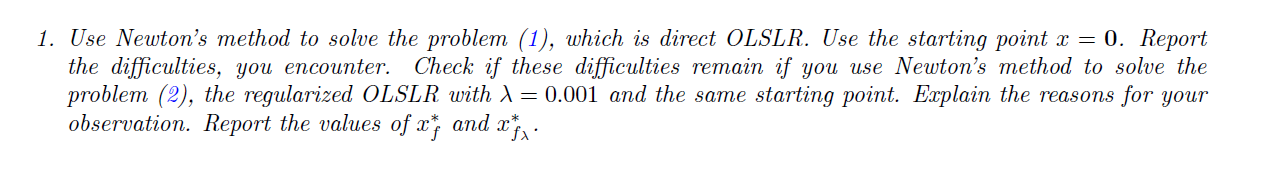

#Excersize 1(1)

In [1]:
import numpy as np  #use the instruction of the given question
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import math

In [2]:
digits = load_digits() #check the shape of digits data
print(digits.data.shape)
print(digits.target.shape)
#let us use the linear regression used in the previous lab
N = digits.data.shape[0] #Number of data points
d = digits.data.shape[1] #Dimension of data points
A = digits.data
y = 1.0*np.ones([A.shape[0],1])     #we create a NX1 vector of target labels
for i in range(digits.target.shape[0]):
 y[i] = digits.target[i]


(1797, 64)
(1797,)


In [3]:
 # define the function
 def evalf(x,lam):
  assert type(x) is np.ndarray
  fval = np.linalg.norm(np.matmul(A,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)
#define the gradient
def evalg(x,lam):
  assert type(x) is np.ndarray
  grad=(lam*x+np.matmul(A.T, np.matmul(A, x) - y))
  return grad

#define the hussian
def evalh(x,lam):
  assert type(x) is np.ndarray
  return np.matmul(A.T,A)+lam*np.identity(d)

In [4]:
def compute_B_k(s, y, B_k):   # define the b_k for using the BFGS algorithm instead of the hussian inverse
  I=np.identity(64)
  assert type(s) is np.ndarray
  assert type(y) is np.ndarray
  assert type(B_k) is np.ndarray
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  c1 = np.outer(np.multiply(mu, s), np.transpose(y))
  c2 = np.outer(np.multiply(mu, y), np.transpose(s))
  a = np.subtract(I, c1)
  b = np.subtract(I, c2)
  c = np.outer(np.multiply(mu, s), np.transpose(s))
  d = np.matmul(np.matmul(a, B_k), b)
  pk = np.add(d, c)
  return pk

In [5]:
#line search type
EXACT_LINE_SEARCH = 0
BACKTRACKING_LINE_SEARCH = 1


In [6]:
def compute_D_k(x):   #comute d_k for using the backtracking algorithm
  assert type(x) is np.ndarray
  mat = evalh(x)
  return np.linalg.inv(mat)

In [7]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k):
  assert type(x) is np.ndarray  #compute the steplength
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0.
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0.
  alpha = alpha_start
  p = - gradf
  D_k = B_k


  while evalf(x + alpha*np.matmul(D_k,p),lam) > evalf(x,lam) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha

In [8]:
def minimizer_Newtonmethod(start_x,lam, tol, line_search_type, *args):  #define the newton method
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam)
  h_x = evalh(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x,lam))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)
    else:
      raise ValueError('Line search type unknown. Please check!')
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x)))
    k = k + 1
    g_x = evalg(x,lam)
  return x,  k

In [9]:
def minimizer_BFGS(start_x, lam,tol, line_search_type, *args):  #define the BFGS algorithms
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(d)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol):
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)

    else:
      raise ValueError('Line search type unknown. Please check!')
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x)))
    g_x = evalg(x_new,lam)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam), evalg(x_old,lam))
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k

In [10]:
my_start_x =np.zeros(d)

In [11]:
my_start_x   #column 64

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Ans(1)**

In [12]:
alpha = 0.99  #we take the alpha from the previous lab
rho = 0.5   # use α0 = 0.99, ρ = 0.5, γ = 0.5  and τ = 10−4
gamma = 0.5
my_tol= 1e-4
lam=0.0 # Here we take the lamda = 0
k1=[]
my_start_x =np.zeros(d)
x, k = minimizer_Newtonmethod(my_start_x.reshape(d,1),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
print('for starting with',my_start_x,':\nwe have minimizer:',x ,'\nno. of iterations:',k)

LinAlgError: Singular matrix

**Observation:-** At lemda =0 it give the singular matrix then we can not find the inverse , It does not depend on the alpha

**Ans 1(2)**

In [13]:
alpha = 0.99  #we take the alpha from the previous lab
rho = 0.5   # use α0 = 0.99, ρ = 0.5, γ = 0.5  and τ = 10−4
gamma = 0.5
my_tol= 1e-4
lam=0.001  #here we take
k1=[]
my_start_x =np.zeros(d)
x, k = minimizer_Newtonmethod(my_start_x.reshape(d,1),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
print('starting with',my_start_x,':\nwe have minimizer:',x)
print('\nno. of iterations:',k)

starting with [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
we have minimizer: [[ 0.00000000e+00]
 [ 9.69076882e-02]
 [-4.32192762e-03]
 [-7.75916338e-03]
 [ 7.49591987e-02]
 [ 1.13946582e-02]
 [-2.71293921e-02]
 [-7.34410664e-03]
 [ 9.98267907e-01]
 [-2.88089376e-02]
 [ 1.18688356e-01]
 [ 6.60922719e-02]
 [-5.57075915e-02]
 [-6.97056149e-02]
 [ 9.65844014e-02]
 [ 2.55196013e-01]
 [-7.29830665e-01]
 [ 2.42711745e-02]
 [ 7.73241544e-02]
 [-2.33008498e-02]
 [-5.64077619e-02]
 [ 5.72413971e-02]
 [-4.88675248e-02]
 [-2.62555998e-01]
 [-9.06071169e-01]
 [-1.49769638e-01]
 [ 5.64022790e-02]
 [ 8.96665319e-02]
 [ 8.39315938e-02]
 [ 9.85410047e-02]
 [ 1.69269848e-03]
 [-2.96649688e+00]
 [ 0.00000000e+00]
 [-1.54361470e-01]
 [-9.32404639e-03]
 [ 1.39497978e-01]
 [-3.69237437e-02]
 [ 5.46111773e-02]
 [-9.20425586e-03]
 [ 0.00000000e+00]
 [ 1.0332

**Observation :-**

(1) By direct OLSLR,Here we get the singular matrix,hence we can not find the inverse of the matrix.and we also cannot calculate the further calculations.

(2) The regularized OLSLR with λ = 0.001 there are 5 iterations and we have find the minimizer in above code.

$\large\textbf{2.}$ Use BFGS method with starting point x = 0, to solve problem (1) and describe if you
observe any difficulty. Check if solving the regularized problem (2) helps (use λ = 0.001 and
starting point x = 0). Explain your observations. Report the values of x∗f
and x∗fλ
.

**Ans 2(1)**

In [14]:
alpha = 0.99  #  use α = 0.99, ρ = 0.5, γ = 0.5  line search and tau = 10−5 from the previous lab
rho = 0.5
gamma = 0.5
my_tol= 1e-5
lam=0   #take the lemda=0
k2=[]

my_start_x =np.zeros(d)

x, k  = minimizer_BFGS(my_start_x.reshape((d,1)),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
print('starting with',my_start_x,':\nwe have minimizer:',x)
print('\nno. of iterations:',k)

starting with [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
we have minimizer: [[ 0.00000000e+00]
 [ 9.69033567e-02]
 [-4.32277231e-03]
 [-7.76028319e-03]
 [ 7.49594380e-02]
 [ 1.13947198e-02]
 [-2.71328245e-02]
 [-7.33176339e-03]
 [ 9.98337970e-01]
 [-2.88095538e-02]
 [ 1.18688288e-01]
 [ 6.60916265e-02]
 [-5.57069862e-02]
 [-6.97063705e-02]
 [ 9.65876439e-02]
 [ 2.55182251e-01]
 [-7.29828616e-01]
 [ 2.42709916e-02]
 [ 7.73249596e-02]
 [-2.33000278e-02]
 [-5.64086144e-02]
 [ 5.72426822e-02]
 [-4.88717684e-02]
 [-2.62467763e-01]
 [-9.06562808e-01]
 [-1.49767791e-01]
 [ 5.64019538e-02]
 [ 8.96663590e-02]
 [ 8.39318159e-02]
 [ 9.85411936e-02]
 [ 1.69317614e-03]
 [-2.96805758e+00]
 [ 0.00000000e+00]
 [-1.54362338e-01]
 [-9.32361206e-03]
 [ 1.39497628e-01]
 [-3.69234835e-02]
 [ 5.46111776e-02]
 [-9.20505069e-03]
 [ 0.00000000e+00]
 [ 1.0327

**Ans 2(2)**

In [15]:
alpha = 0.99    #  use α = 0.99, ρ = 0.5, γ = 0.5  line search and tau = 10−5 from the previous lab
rho = 0.5
gamma = 0.5
my_tol= 1e-5
lam=0.01  #take the lemda =0.01
k2=[]

my_start_x =np.zeros(d)

x, k  = minimizer_BFGS(my_start_x.reshape((d,1)),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
print('starting with',my_start_x,':\nwe have minimizer:',x)
print('\nno. of iterations:',k)

starting with [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
we have minimizer: [[ 0.00000000e+00]
 [ 9.69454404e-02]
 [-4.31446849e-03]
 [-7.74917421e-03]
 [ 7.49570484e-02]
 [ 1.13941447e-02]
 [-2.70987371e-02]
 [-7.45438683e-03]
 [ 9.97636089e-01]
 [-2.88033068e-02]
 [ 1.18688919e-01]
 [ 6.60980384e-02]
 [-5.57129789e-02]
 [-6.96988457e-02]
 [ 9.65553940e-02]
 [ 2.55319017e-01]
 [-7.29838668e-01]
 [ 2.42727520e-02]
 [ 7.73169898e-02]
 [-2.33081963e-02]
 [-5.64001774e-02]
 [ 5.72299358e-02]
 [-4.88296221e-02]
 [-2.63344754e-01]
 [-9.01680421e-01]
 [-1.49786162e-01]
 [ 5.64051960e-02]
 [ 8.96680573e-02]
 [ 8.39296141e-02]
 [ 9.85393248e-02]
 [ 1.68842087e-03]
 [-2.95254338e+00]
 [ 0.00000000e+00]
 [-1.54353657e-01]
 [-9.32794822e-03]
 [ 1.39501088e-01]
 [-3.69260266e-02]
 [ 5.46111604e-02]
 [-9.19716548e-03]
 [ 0.00000000e+00]
 [ 1.0374

**Ans 2(3)**

In [16]:
alpha = 0.99    #  use α = 0.99, ρ = 0.5, γ = 0.5  line search and tau = 10−5 from the previous lab
rho = 0.5
gamma = 0.5
my_tol= 1e-5
lam=0.001  #take the lemda =0.001
k2=[]

my_start_x =np.zeros(d)

x, k  = minimizer_BFGS(my_start_x.reshape((d,1)),lam, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
print('for starting with',my_start_x,':\nwe have minimizer:',x)
print('\nno. of iterations:',k)

for starting with [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
we have minimizer: [[ 0.00000000e+00]
 [ 9.69076881e-02]
 [-4.32192766e-03]
 [-7.75916337e-03]
 [ 7.49591987e-02]
 [ 1.13946582e-02]
 [-2.71293921e-02]
 [-7.34410688e-03]
 [ 9.98267903e-01]
 [-2.88089376e-02]
 [ 1.18688356e-01]
 [ 6.60922719e-02]
 [-5.57075915e-02]
 [-6.97056149e-02]
 [ 9.65844013e-02]
 [ 2.55196013e-01]
 [-7.29830645e-01]
 [ 2.42711745e-02]
 [ 7.73241544e-02]
 [-2.33008498e-02]
 [-5.64077619e-02]
 [ 5.72413971e-02]
 [-4.88675247e-02]
 [-2.62555999e-01]
 [-9.06071227e-01]
 [-1.49769638e-01]
 [ 5.64022789e-02]
 [ 8.96665319e-02]
 [ 8.39315938e-02]
 [ 9.85410047e-02]
 [ 1.69269846e-03]
 [-2.96649685e+00]
 [ 0.00000000e+00]
 [-1.54361470e-01]
 [-9.32404639e-03]
 [ 1.39497978e-01]
 [-3.69237437e-02]
 [ 5.46111773e-02]
 [-9.20425587e-03]
 [ 0.00000000e+00]
 [ 1.

**Obesrvation:-**

**Ans1:-**By using the Regularized OLSLR the number of iteration at the lemda =0 are 69 and the minimizer in the above printed.


**Ans2:-**By using the Regularized OLSLR the number of iteration at the lemda =0.1 are 69 , we see that there are no difference between the iterations and the minimizer in the above printed.


**Ans3:-**By using the Regularized OLSLR the number of iteration at the lemda =0.001 are 70 , we see that there are lemda value decrease , the
 number of iteration are  increased and the minimizer in the above printed .